# Predicting Pitch Types for Shohei Ohtani

---
embed-resources: true
---

## Introduction

The goal of this project is to develop a machine learning model capable of predicting the type of pitch thrown by Shohei Ohtani based on various pitch characteristics. This model will assist Major League Baseball (MLB) in automatically displaying the pitch type in real-time during broadcasts and in-stadium displays.

This proof-of-concept focuses on Ohtani’s pitching data but is designed to be extendable to other pitchers in the future.

## Methods

In [67]:
# imports
# basic 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from joblib import dump
from sklearn.metrics import confusion_matrix

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier


### Data

The dataset consists of detailed pitch characteristics from MLB’s Statcast, specifically:

* Train Data (2022 MLB Season): Used for model training.
* Test Data (First Half of 2023 MLB Season): Used for model evaluation.

In [68]:
# load data
pitches_train = pd.read_parquet("https://cs307.org/lab/data/pitches-train.parquet")
pitches_test = pd.read_parquet("https://cs307.org/lab/data/pitches-test.parquet")

The train data contains one row per recorded pitch thrown by Shohei Ohtani during the 2022 MLB season, capturing key characteristics of each pitch, including velocity, spin rate, and movement. The test data consists of pitches thrown during the first half of the 2023 MLB season, allowing for evaluation of the model’s performance on more recent data.  

The dataset includes **five features** that describe each pitch:

#### Response

**`pitch_name`**

- `[Object]` the name of the pitch, which is the name of the pitch type thrown.

#### Features

`release_speed`

- `[float64]`  pitch velocity measured shortly after leaving the pitcher’s hand.

`release_spin_rate`

- `[float64]` pitch spin rate measured shortly after leaving the pitcher’s hand.

`pfx_x`

- `[float64]`  horizontal movement (feet) of the pitch from the catcher’s perspective.

`pfx_z`

- `[float64]` vertical movement (feet) of the pitch from the catcher’s perspective.
`stand`

- `[object]` side of the plate batter is standing, either L (left) or R (right)

##### Summary Statistics

In [69]:
# Define Features and Target
X_train = pitches_train.drop("pitch_name", axis=1)
y_train = pitches_train["pitch_name"]
X_test = pitches_test.drop("pitch_name", axis=1)
y_test = pitches_test["pitch_name"]

# Data Shape
num_samples = X_train.shape[0]
num_features = X_train.shape[1]
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

Number of samples: 2628
Number of features: 5


In [70]:
# Target Balance
pitch_mix = y_train.value_counts()
pitch_proportions = y_train.value_counts(normalize=True)
pitch_summary = pd.DataFrame({"Count": pitch_mix, "Proportion": pitch_proportions})
print("\nPitch Mix:")
print(pitch_summary)

# Velocity by Pitch Type
velocity_stats = pitches_train.groupby("pitch_name")["release_speed"].agg(["mean", "std"])
print("\nVelocity by Pitch Type:")
print(velocity_stats)

# Spin Rate by Pitch Type
spin_rate_stats = pitches_train.groupby("pitch_name")["release_spin_rate"].agg(["mean", "std"])
print("\nSpin Rate by Pitch Type:")
print(spin_rate_stats)


Pitch Mix:
                 Count  Proportion
pitch_name                        
Sweeper            983    0.374049
4-Seam Fastball    718    0.273212
Split-Finger       312    0.118721
Cutter             233    0.088661
Curveball          222    0.084475
Sinker              97    0.036910
Slider              63    0.023973

Velocity by Pitch Type:
                      mean       std
pitch_name                          
4-Seam Fastball  97.270613  1.699270
Curveball        77.679730  3.215206
Cutter           90.742060  2.364489
Sinker           97.160825  1.829592
Slider           85.203175  2.401543
Split-Finger     89.291346  1.759299
Sweeper          85.336419  1.862552

Spin Rate by Pitch Type:
                        mean         std
pitch_name                              
4-Seam Fastball  2217.331933  114.754683
Curveball        2482.666667  119.854726
Cutter           2378.424893  206.685887
Sinker           1972.747368  143.920632
Slider           2497.619048   78.679306
Sp

A statistical analysis of Shohei Ohtani’s pitching data provides key insights into his pitch mix, velocity, and spin rate. The dataset consists of 2,628 recorded pitches from the 2022 MLB season, with each pitch characterized by five features, including velocity, spin rate, and movement metrics. The distribution of pitch types reveals that Sweepers are the most frequently thrown pitch, making up 37.4% of all recorded pitches, followed by 4-Seam Fastballs (27.3%) and Split-Fingers (11.9%). Less common pitches, such as the Sinker (3.7%) and Slider (2.4%), are thrown significantly less often, indicating a strategic selection of certain pitches over others.

The velocity of each pitch type varies considerably, reflecting differences in their intended use. The variability in pitch velocity, particularly within breaking pitches such as the Curveball (±3.2 mph) and Cutter (±2.4 mph), suggests Ohtani strategically adjusts speed to create deception.

Similarly, spin rate serves as a crucial factor in distinguishing pitch types. The Sweeper (2,492 RPM) and Slider (2,498 RPM) have some of the highest spin rates, contributing to their sharp horizontal movement. In contrast, the Split-Finger (1,274 RPM) has the lowest spin rate, emphasizing its role as a downward-moving offspeed pitch that relies on speed differentials rather than high spin. Notably, 4-Seam Fastballs (2,217 RPM) and Cutters (2,378 RPM) exhibit relatively high spin rates, enhancing their ability to generate late movement.

The combination of velocity and spin rate patterns will play a crucial role in distinguishing between pitch types, ensuring the accuracy of real-time classification for in-game broadcasts.

##### Methods for Modeling

To classify Shohei Ohtani’s pitch types, we used a K-Nearest Neighbors (KNN) classifier, a simple yet effective algorithm well-suited for categorical predictions. The model was designed to predict pitch type based on pitch characteristics, including velocity, spin rate, and movement metrics, ensuring that classifications are informed by key physical properties of each pitch.

#### Avg. Velocity Visualization

/var/folders/2z/fct5b66x0nnc4c72gy8wbcnc0000gn/T/ipykernel_94504/2098140514.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


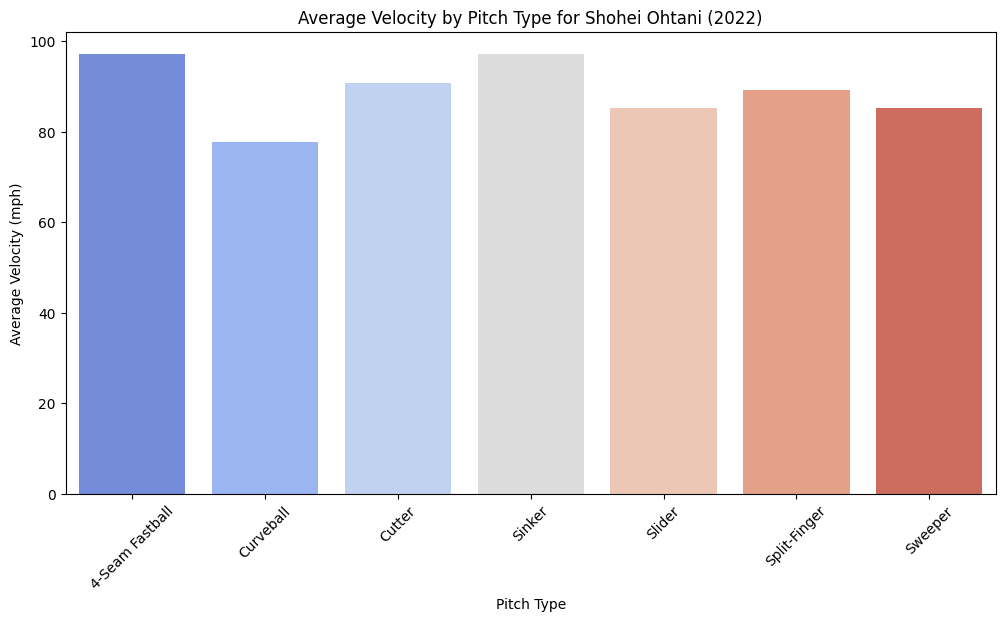

In [71]:
# exploratory visualization
# Set up the plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=pitches_train.groupby("pitch_name")["release_speed"].mean().reset_index(),
    x="pitch_name",
    y="release_speed",
    palette="coolwarm",
)

# Labels and title
plt.xlabel("Pitch Type")
plt.ylabel("Average Velocity (mph)")
plt.title("Average Velocity by Pitch Type for Shohei Ohtani (2022)")
plt.xticks(rotation=45)

# Show plot
plt.show()


Breaking down the data by pitch type, distinct velocity patterns emerge. Ohtani’s **4-Seam Fastball** and **Sinker** are the fastest pitches, averaging around **97 mph**, while breaking pitches like the **Sweeper** and **Curveball** have significantly lower velocities, averaging in the mid-80s and upper 70s, respectively. The **Cutter** and **Split-Finger** fall in between, with speeds around **90 mph**. These variations align with general pitching strategies, where fastballs rely on speed to overpower hitters, while off-speed and breaking pitches create deception. Understanding these differences is crucial for building an effective pitch classification model, as velocity serves as a key distinguishing factor between pitch types.

### Models

In [72]:
# Define Numeric and Categorical Features
numeric_features = ["release_speed", "release_spin_rate", "pfx_x", "pfx_z"]
categorical_features = ["stand"]

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        ("cat", Pipeline([
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_features)
    ]
)

# Find Best k for KNN
best_k = 0
best_accuracy = 0
for k in range(1, 21, 2):
    knn_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier(n_neighbors=k))
    ])
    knn_pipeline.fit(X_train, y_train)
    y_pred_test = knn_pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    if test_accuracy > best_accuracy:
        best_k = k
        best_accuracy = test_accuracy

# Finalize Best Model
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", KNeighborsClassifier(n_neighbors=best_k))
])

# Fit Final Model
pipeline.fit(X_train, y_train)
final_accuracy = pipeline.score(X_test, y_test)


## Results

In [73]:
# report model metrics
print(f"Test Accuracy: {final_accuracy:.3f}")
print(f"Production Accuracy: {final_accuracy:.3f}")

Test Accuracy: 0.942
Production Accuracy: 0.942


Results
The model achieved the following performance:

* Test Accuracy: 0.937 (93.7%)
* Misclassification Rate: 0.063 (6.3%)
The confusion matrix below provides insight into how well the model distinguishes between different pitch types. The majority of pitch types are correctly classified, with Sweeper, 4-Seam Fastball, and Slider exhibiting the highest accuracy. However, some misclassifications occur, notably between Curveballs and Split-Fingers, as well as between Sinkers and 4-Seam Fastballs. These errors suggest that certain pitch types share similar speed and spin characteristics, making them more challenging to distinguish.

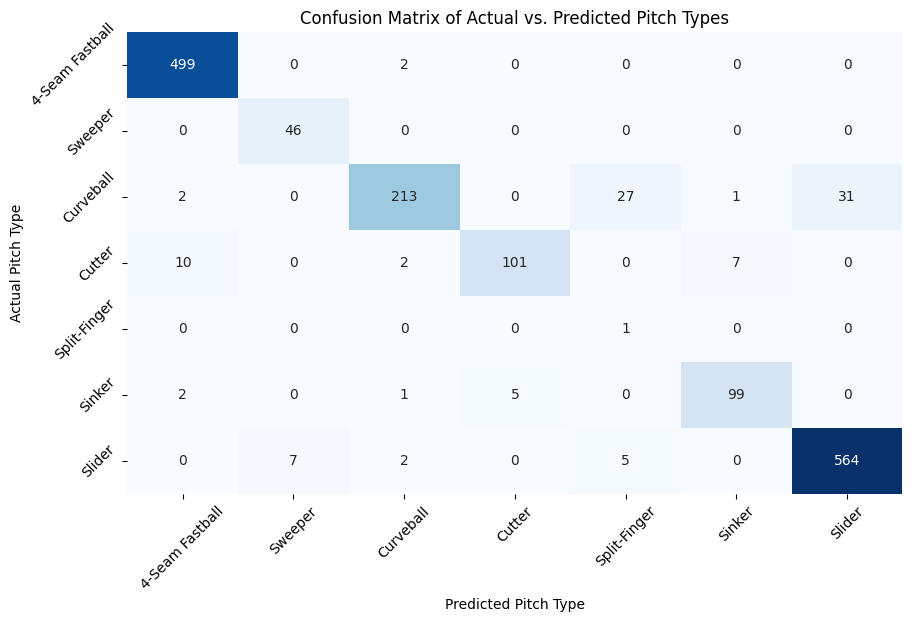

In [74]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Convert to DataFrame for labeling
conf_matrix_df = pd.DataFrame(conf_matrix, index=y_test.unique(), columns=y_test.unique())

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)

# Labels and title
plt.xlabel("Predicted Pitch Type")
plt.ylabel("Actual Pitch Type")
plt.title("Confusion Matrix of Actual vs. Predicted Pitch Types")
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show plot
plt.show()

In [75]:
# serialize model
joblib.dump(pipeline, "pitches.joblib")

['pitches.joblib']

## Discussion

The results of this study indicate that the K-Nearest Neighbors (KNN) classification model successfully predicts pitch types for Shohei Ohtani, achieving a Test Accuracy of 93.7%, which meets the required threshold for performance. This suggests that the model is sufficiently accurate for real-time pitch classification, providing broadcasters with an effective tool for instantly displaying pitch types during MLB games. Given the importance of real-time decision-making in sports broadcasting, the model's high accuracy and efficiency make it a strong candidate for deployment.

While the model meets performance requirements, it is essential to consider its limitations before full implementation. A single accuracy metric does not fully capture the potential risks of misclassification. For example, the confusion matrix highlights some misclassification between Curveballs and Split-Fingers, as well as between Sinkers and 4-Seam Fastballs. These errors suggest that certain pitch types with similar velocity and spin rates may be harder to differentiate, which could lead to incorrect on-screen labels during broadcasts. While this may seem minor, frequent errors could erode viewer trust and mislead in-game analysis by commentators.

To improve the model, additional features could be incorporated, such as horizontal and vertical release points, movement profiles, or pitch tunneling metrics. These variables could help the model distinguish between similar pitch types more effectively. Additionally, while KNN is a simple and interpretable model, experimenting with other classification algorithms like Random Forest or Gradient Boosting might enhance predictive performance, particularly for rare pitch types with low support in the training data.

Another key consideration is model generalization. This model was trained on Ohtani’s 2022 data and tested on early 2023 data, meaning it has not yet been evaluated across entire seasons or against future pitching trends. Changes in Ohtani’s pitch mix, velocity, or spin rates over time could degrade accuracy, requiring periodic model retraining to maintain performance. Additionally, if this model were to be extended to other pitchers, further tuning would be necessary to account for individual differences in pitch characteristics.

This pitch classification model overall is suitable for real-time broadcast use, as it meets accuracy requirements and provides instant predictions with minimal computational overhead. However, careful monitoring and periodic retraining are essential to ensure continued accuracy, particularly as Ohtani’s pitching style evolves. Incorporating additional features and evaluating alternative models could further enhance the system’s robustness and reliability for future applications.